<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML-in-Business_practice/blob/master/ch6_NN/Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
base_url = "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/ch6_NN"
!wget -O "utils.py" "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/utils.py"
!wget -O "linear.py" "$base_url/linear.py"
!wget -O "common.py" "$base_url/common.py"
!wget -O "models.py" "$base_url/models.py"
!wget -O "training.py" "$base_url/training.py"

from linear import normal_equation
from common import fetch_iowa, stdize
from models import SingleLayerModel, MultiLayerModel
from training import train_step, test_step
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#@title the best predictions we can possibly achieve ... ?
(x_train, x_test), (y_train, y_test) = fetch_iowa()
best_params = normal_equation(x_train, y_train)
pred = (x_train @ best_params).astype(int)

print(pred[:5])
print(y_train[:5])

print(f"{mean_squared_error(y_train, pred):.2E}")

[219747 151636 224087 221452 266039]
[208500 181500 223500 140000 250000]
2.10E+09


In [3]:
x_train_stdized, x_test_stdized = stdize(x_train, x_test)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_stdized, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_stdized, y_test)).batch(32)

train_loss = tf.keras.metrics.Sum('train_loss')
test_loss = tf.keras.metrics.Sum('test_loss')
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=.01)
model = MultiLayerModel()

train_history = []
test_history = []
for epoch in range(10):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        loss = train_step(x, y, model, loss_object, optimizer)
        train_loss(loss * len(y)) # squared error
    
    for x, y in test_ds:
        t_loss = test_step(x, y, model, loss_object)
        test_loss(t_loss * len(y)) # squared error

    train_history.append(train_loss.result()/len(x_train))
    test_history.append(test_loss.result()/len(x_test))

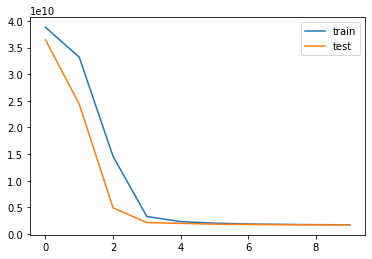

train_mse: 1.74E+09
test_mse: 1.71E+09


In [4]:
plt.plot(train_history)
plt.plot(test_history)
plt.legend(['train', 'test'])
plt.show()
print(f"train_mse: {train_history[-1]:.2E}")
print(f"test_mse: {test_history[-1]:.2E}")

In [5]:
pred = model(x_test_stdized).numpy().ravel().astype(int)
print(pred[:5])
print(y_test[:5])

[269797 273383 209599 167560 219285]
[212700 256000 230348 188000 192500]


In [8]:
train_loss = tf.keras.metrics.Sum('train_loss')
test_loss = tf.keras.metrics.Sum('test_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7)
model = SingleLayerModel()

train_history = []
test_history = []
for epoch in range(10):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        loss = train_step(x, y, model, loss_object, optimizer)
        train_loss(loss * len(y)) # squared error

    for x, y in test_ds:
        t_loss = test_step(x, y, model, loss_object)
        test_loss(t_loss * len(y)) # squared error

    train_history.append(train_loss.result()/len(x_train))
    test_history.append(test_loss.result()/len(x_test))

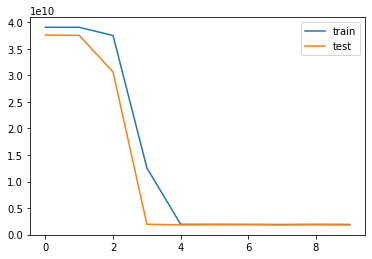

train_mse: 1.91E+09
test_mse: 1.82E+09


In [9]:
plt.plot(train_history)
plt.plot(test_history)
plt.legend(['train', 'test'])
plt.show()
print(f"train_mse: {train_history[-1]:.2E}")
print(f"test_mse: {test_history[-1]:.2E}")

In [10]:
pred = model(x_test_stdized).numpy().ravel().astype(int)
print(pred[:5])
print(y_test[:5])

[263782 267971 216548 177230 227680]
[212700 256000 230348 188000 192500]




*   如何計算出 output -> current predictions  (實作)
*   Automatic Diffentiation(AD) -> get gradients  (未實作)
*   如何使用 gradients 提高模型準度 -> gradient descent methods (解說)



In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7)

tf.random.set_seed(3)
model = SingleLayerModel()

def train_step_with_details(x, y, i=0):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_object(y, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    if i:
        print("gradients:")
        print(np.r_[gradients[0].numpy(), gradients[1].numpy().reshape(1, -1)])
        print(np.r_[gradients[2].numpy(), gradients[3].numpy().reshape(1, -1)])
        print()
        
        print("original weights:")
        print(np.r_[model.weights[0].numpy(), model.weights[1].numpy().reshape(1, -1)])
        print(np.r_[model.weights[2].numpy(), model.weights[3].numpy().reshape(1, -1)])
        print()

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    if i:
        print("modified weights:")
        print(np.r_[model.weights[0].numpy(), model.weights[1].numpy().reshape(1, -1)])
        print(np.r_[model.weights[2].numpy(), model.weights[3].numpy().reshape(1, -1)])
        print()

        print("original output:\n", y_pred, '\n')
        print("modified output:\n", model(x), '\n')
        print("y true", y, '\n')

train_ds = tf.data.Dataset.from_tensor_slices((x_train_stdized[:, :2], y_train)).shuffle(10000).batch(1)

first_data = list(train_ds.take(1))[0]
x = first_data[0].numpy()
y = first_data[1].numpy()
first_data = np.c_[list(train_ds.take(1))[0][0].numpy(), 1]
print("input:\n", x, '\n')
train_step_with_details(x, y, i=1)

input:
 [[ 0.45386352 -0.8057162 ]] 

gradients:
[[ 54826.496      0.         0.   ]
 [-97330.125      0.         0.   ]
 [120799.516      0.         0.   ]]
[[ -85930.15]
 [      0.  ]
 [      0.  ]
 [-336000.2 ]]

original weights:
[[-0.66915953 -0.68732166 -0.8237487 ]
 [-0.694353    0.15731323  0.63675463]
 [ 0.          0.          0.        ]]
[[-0.35952216]
 [ 0.7060987 ]
 [-1.2130281 ]
 [ 0.        ]]

modified weights:
[[-0.6746422  -0.68732166 -0.8237487 ]
 [-0.68461996  0.15731323  0.63675463]
 [-0.01207995  0.          0.        ]]
[[-0.35092914]
 [ 0.7060987 ]
 [-1.2130281 ]
 [ 0.03360002]]

original output:
 tf.Tensor([[-0.09194576]], shape=(1, 1), dtype=float32) 

modified output:
 tf.Tensor([[-0.04828367]], shape=(1, 1), dtype=float32) 

y true [168000] 



In [ ]:
def sigmoid(raw_output):
    return 1 / (1 + np.exp(-raw_output))

def linear(raw_output):
    return raw_output

def relu(raw_output):
    return (abs(raw_output) + raw_output) / 2


weights = {
    'layer_1': np.array([[-0.66915953, -0.68732166, -0.8237487 ],
                         [-0.694353,    0.15731323,  0.63675463],
                         [ 0.,          0.,          0.,        ]]),
    'final_layer': np.array([[-0.35952216],
                             [ 0.7060987 ],
                             [-1.2130281 ],
                             [ 0.        ]])
}
activations = {
    'layer_1': relu,
    'final_layer': linear
}

data = np.c_[x_train_stdized[:, :2], np.ones(len(x_train_stdized))]
first_data = np.c_[x, 1]
neuron_val = first_data
for ith_layer in weights:
    print("{}個 input value + bias 1:".format(neuron_val.shape[1]-1), neuron_val.shape)
    print("{} input, {} output:".format(*weights[ith_layer].shape), weights[ith_layer].shape)
    neuron_val = activations[ith_layer](neuron_val @ weights[ith_layer])
    if ith_layer != 'final_layer':
        neuron_val = np.c_[neuron_val, np.ones(first_data.shape[0])]
        print("{} output + bias 1:".format(neuron_val.shape[1]-1), neuron_val.shape)
    else:
        print("1 個 output:", neuron_val.shape)
    print()
print(neuron_val[0])

2個 input value + bias 1: (1, 3)
3 input, 3 output: (3, 3)
3 output + bias 1: (1, 4)

3個 input value + bias 1: (1, 4)
4 input, 1 output: (4, 1)
1 個 output: (1, 1)

[-0.09194576]


# Gradient Descent methods

## SGD 

compute gradients with
*   the whole dataset
*   a single instance
*   a batch

## challenges:


*   Choose proper lr at each stage
*   Choose proper lr for each feature 
    * larger update for rarely ocurring features
    * gradient 越大 -> learning rate 應該越大?
*   Escape from local minimum / saddle point

## Momentum 
reduce oscillation \\
>$v_t = momentum * v_{t-1} + \eta * \nabla L(\theta_{t-1}), momentum < 1$ \\
>$\theta_t = \theta_{t-1} - v_t$ \\

batch size 很小， gradient方向頻繁變動， \\
增加與過往同方向的 gradient 大小， \\
減少與過往反方向的 gradient 大小

## Adagrad 

>$ \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + \epsilon}}\nabla L$ \\
>$ \epsilon = 1e-8, G_t$ is a diagonal matrix, $G_{(t-1, ii)} = \sum_{i=0}^{t-1} (\nabla L(\theta_i))^2 $ \\
<br>
>問題： 隨著 $ G_t $ 累加，learning rate 會過小（失去本意）

## RMSprop

>$ \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{E[g^2]_{t-1} + \epsilon}}\nabla L$ \\
>$ E[g^2]_{t-1} = 0.9 E[g^2]_{t-2} + 0.1 g_{t-1}^2 $ \\
<br>
>解決 Adagrad 的問題

## Adam (RMSprop + momentum)

>$ m_t = \beta_1 m_{t-1} * (1 - \beta_1) g_t $   ------ momentum \\
>$ v_t = \beta_2 v_{t-1} * (1 - \beta_2) g_t^2 $ ------ RMSprop \\
>$ \hat{m_t} = \frac{m_t}{1 - \beta_1} $, 
>$ \hat{v_t} = \frac{v_t}{1 - \beta_2} $  ------ 讓一開始的 $m_t, v_t$ 不要太小 \\
<br>
>$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v_t}} + \epsilon} \hat{m_t} $

# 用 NN approx. BSM model

In [11]:
n = 60000
np.random.seed(3)

N_ = stats.norm(loc=0.0, scale=1.0)
N = lambda d: N_.cdf(d)

bounds = [(40, 60), (0.5, 1.5), (0, 0.05), (0.1, 0.4), (0.25, 2)]
S, K, r, sigma, T = [np.random.uniform(*bound, (n, 1)).round(3) for bound in bounds]
K = S * K

d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
d2 = (np.log(S/K) + (r - sigma**2/2)*T)/(sigma * np.sqrt(T))

option_price = S * N(d1) - K * np.exp(-r*T) * N(d2)
option_price_with_noise = option_price + np.random.normal(0.0, .15, (n, 1))

In [12]:
x = np.c_[S, K, r, sigma, T]
y = option_price_with_noise
x_train, x_r, y_train, y_r =  train_test_split(x, y, train_size=1/3, random_state=3)
x_val, x_test, y_val, y_test =  train_test_split(x_r, y_r, test_size=1/2, random_state=3)

x_train_stdized, x_val_stdized = stdize(x_train, x_val)
_, x_test_stdized = stdize(x_train, x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train_stdized, y_train)).shuffle(10000).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_stdized, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_stdized, y_test)).batch(32)

In [17]:
model = MultiLayerModel()
model.compile(optimizer='Adam', loss='mae')

# callbacks
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=60,
                    callbacks=[es, reduce_lr],
                    verbose=0)

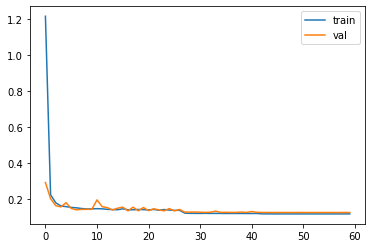

train_mse: 0.1165
val_mse: 0.1245


In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()
print(f"train_mse: {history.history['loss'][-1]:.4f}")
print(f"val_mse: {history.history['val_loss'][-1]:.4f}")

$y = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{x^2}{2 \sigma^2}}$ \\
<br>
$E[|X|]$ \\
>> $ = \frac{1}{\sigma \sqrt{2\pi}} (\int_{-\infty}^0 -x e^{-\frac{x^2}{2 \sigma^2}} dx + \int_0^{\infty}x e^{-\frac{x^2}{2 \sigma^2}} dx $) \\
<br>
>> let $t = \frac{x}{\sqrt2\sigma}, dt = \frac{1}{\sqrt2\sigma} dx$ \\
<br>
>> $ = \frac{1}{\sqrt{\pi}} (\int_{-\infty}^0 -\sqrt2\sigma t e^{-t^2} dt + \int_0^{\infty} \sqrt2\sigma t e^{-t^2} dt)$ (上下限不動) \\
<br>$f(t) = t e^{-t}$ 為奇函數 \\
<br>
>> $ = \sqrt{\frac{2}{\pi}}\sigma * 2 \int_0^{\infty} t e^{-t^2} dt)$ \\
<br>
>> let $u = -t^2, du = -2tdt, -\frac{1}{2}du = tdt$ \\
<br>
>> $ = \sqrt{\frac{2}{\pi}}\sigma * (- \int_0^{-\infty} e^u du))$ \\
<br>
>> $ = \sqrt{\frac{2}{\pi}}\sigma $

In [ ]:
round(np.sqrt(2/np.pi) * 0.15, 4)

0.1197

# Autoencoders